### Data Import
Import the data from the data directory containing METRo forecasts and monitor data from 29th of October 2018 till the 14th of March 2019.

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES

def loader():
    """Reading data from keys"""
    with open("data/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data/data_{}.csv".format(str(key)))

    return dictex

df = loader()

def getValues(data, raw=False):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))

    rsi = {
        "data": data.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
        "target": data.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
    }
    
    if (raw):
        return train_test_split(rsi["data"], rsi["target"], test_size=0.0, random_state=0)
    return train_test_split(rsi["data"], rsi["target"], test_size=0.3, random_state=0)

### Getting the mean value from all values

In [ ]:
means = []

for key in df.keys():
    if allowed_key(key):
        means.append(np.mean(df[key]['surf_temp_sqerror']))
        
np.mean(means)

1.472554949844182

### Categorize values of the test data

This section categorizes the values into different sections depending on the target value. 

In [ ]:
results = dict()
df = loader()

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        is_below_one = 0
        is_below_five = 0
        is_below_ten = 0
        is_below_twenty = 0
        is_above_twenty = 0
        
        # For the chronological dataset, use this definition of data
        data = df[key]['surf_temp_sqerror'][-int(len(df[key]['surf_temp_sqerror']) * .3):]
        
        # For the non-chronological dataset, use this instead
        # X_train, X_test, y_train, y_test = getValues(df[(key)])
        # data = y_test
        
        for val in data:
            if (val <= 1):
                is_below_one += 1
            elif (1 < val <= 5):
                is_below_five += 1
            elif (5 < val <= 10):
                is_below_ten += 1
            elif (10 < val <= 20):
                is_below_twenty += 1
            else:
                is_above_twenty += 1
        results[key] = (is_below_one, is_below_five, is_below_ten, is_below_twenty, is_above_twenty)

### Visualize data categories per station

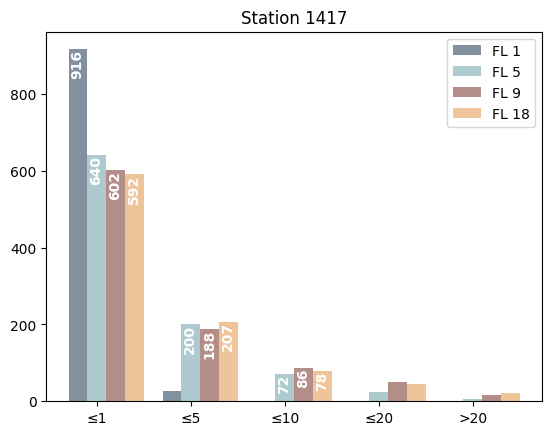

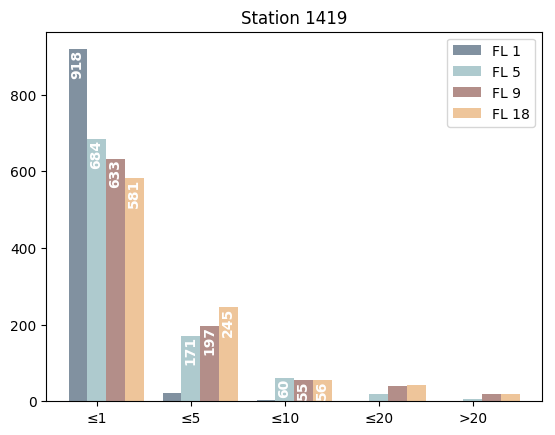

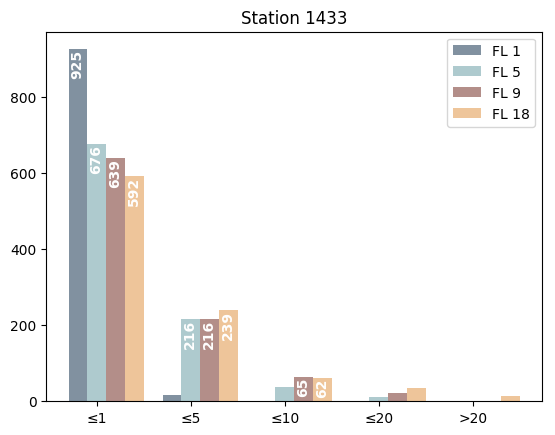

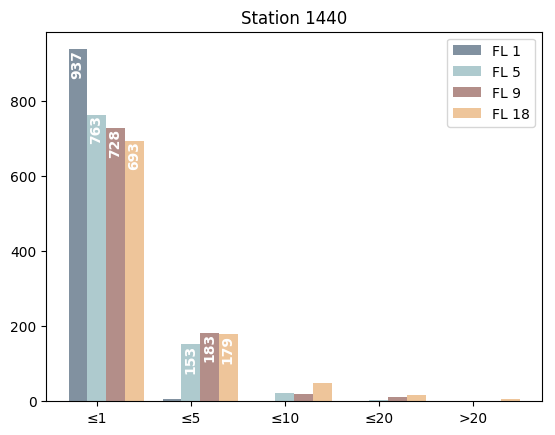

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.font_manager import FontProperties
import datetime

plt.rcdefaults()

for key in [1417, 1419, 1433, 1440]:
    x = ['≤1', '≤5', '≤10', '≤20', '>20']
    ind = np.arange(len(x))

    y = results[(key, 1)]
    z = results[(key, 5)]
    k = results[(key, 9)]
    d = results[(key, 18)]

    ax = plt.subplot(111)

    ax.set_title('Station {}'.format(str(key)))
    ax.set_xticks(ind)
    ax.set_xticklabels(('≤1', '≤5', '≤10', '≤20', '>20'))

    bar1 = ax.bar(ind-0.2, y, width=0.2, color='#8191A0', align='center', label='FL 1')
    bar2 = ax.bar(ind, z, width=0.2, color='#AECACE', align='center', label='FL 5')
    bar3 = ax.bar(ind+0.2, k, width=0.2, color='#B38E89', align='center', label='FL 9')
    bar4 = ax.bar(ind+0.4, d, width=0.2, color='#EEC59A', align='center', label='FL 18')
    ax.legend(loc=1)
    
    # Add counts above the two bar graphs
    for rect in bar1 + bar2 + bar3 + bar4:
        font0 = FontProperties()
        font = font0.copy()
        font.set_weight('bold')
        height = rect.get_height()
        if (int(height) > 50):
            plt.text(rect.get_x() + rect.get_width()/10.0, height, '%d' % int(height), ha='left', va='top', fontsize=9, color='white', rotation=90, fontproperties=font)

    plt.savefig('sse_values_30_percent_{}.png'.format(str(key)))
    plt.show()

### Visualization of the data categories in general

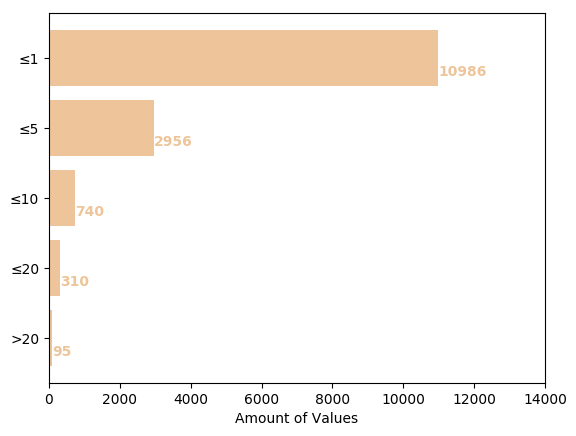

In [ ]:
%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ranges = ('≤1', '≤5', '≤10', '≤20', '>20')
y_pos = np.arange(len(ranges))
performance = [is_below_one, is_below_five, is_below_ten, is_below_twenty, is_above_twenty]

ax.barh(y_pos, performance, align='center', color='#EEC59A')
ax.set_yticks(y_pos)
ax.set_yticklabels(ranges)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Amount of Values')
ax.set_xlim([0, 14000])

for i, v in enumerate(performance):
    ax.text(v + 3, i + .25, str(v), color='#EEC59A', fontweight='bold')

#plt.savefig('data_analysis_test_random.png')
plt.show()

### Analyzing the feature score

In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

df = loader()
X_train, X_test, y_train, y_test = getValues(df[(1417, 18)], raw=True)

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(INDEPENDENT_FEATURES)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(len(INDEPENDENT_FEATURES),'Score'))  #print 10 best features

                    Specs       Score
9      OctalCloudCoverage  126.294139
0               radiation  112.837278
14           water_amount  103.780462
1                   shade   63.168274
7               WindSpeed   60.879378
8             AirPressure   56.212548
10           PrecipAmount   44.884751
4              RainPrecip   35.515645
6   SnowPrecipAccumulated   24.117755
5              SnowPrecip   17.301234
12              dew_point   16.259632
3                DewPoint   16.231913
15            snow_amount    2.433639
11               air_temp    1.467901
2                 AirTemp    1.467901
13              surf_temp    0.003595
16               sub_temp    0.001070


In [16]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

def loader2():
    """Reading data from keys"""
    with open("data2/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data2/data_{}.csv".format(str(key)))

    return dictex

df = loader2()

X_train, X_test, y_train, y_test = getValues(df[(1417, 1)], raw=True)

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(INDEPENDENT_FEATURES)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(len(INDEPENDENT_FEATURES),'Score'))  #print 10 best features

                    Specs      Score
0               radiation  62.633310
1                   shade  42.664603
13              surf_temp  29.929493
9      OctalCloudCoverage  19.136076
11               air_temp  17.824334
2                 AirTemp  14.181348
12              dew_point   3.898907
7               WindSpeed   3.640611
3                DewPoint   2.361171
14           water_amount   0.968802
8             AirPressure   0.124318
5              SnowPrecip   0.121262
6   SnowPrecipAccumulated   0.121262
16               sub_temp   0.074755
10           PrecipAmount   0.024351
4              RainPrecip   0.021871


/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


### Heatmap for displaying feature relations

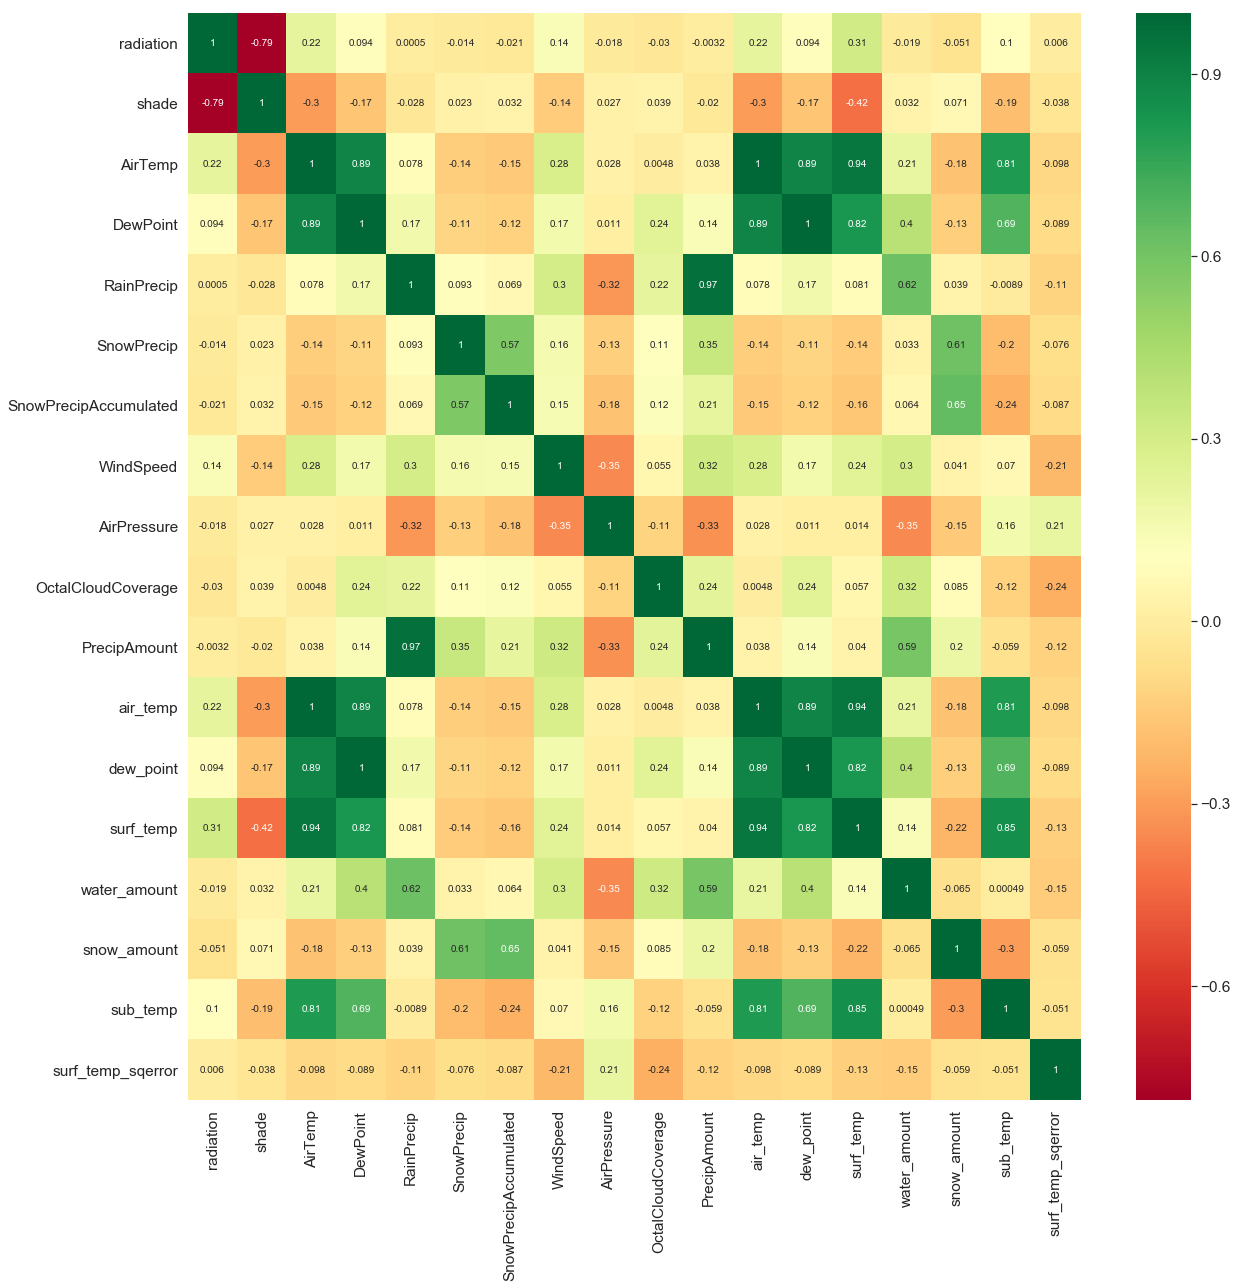

In [63]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = loader()[(1440, 18)].filter(INDEPENDENT_FEATURES + ['surf_temp_sqerror'])
df = loader()
X, X_test, y, y_test = getValues(df[(1440, 18)], raw=True)

#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

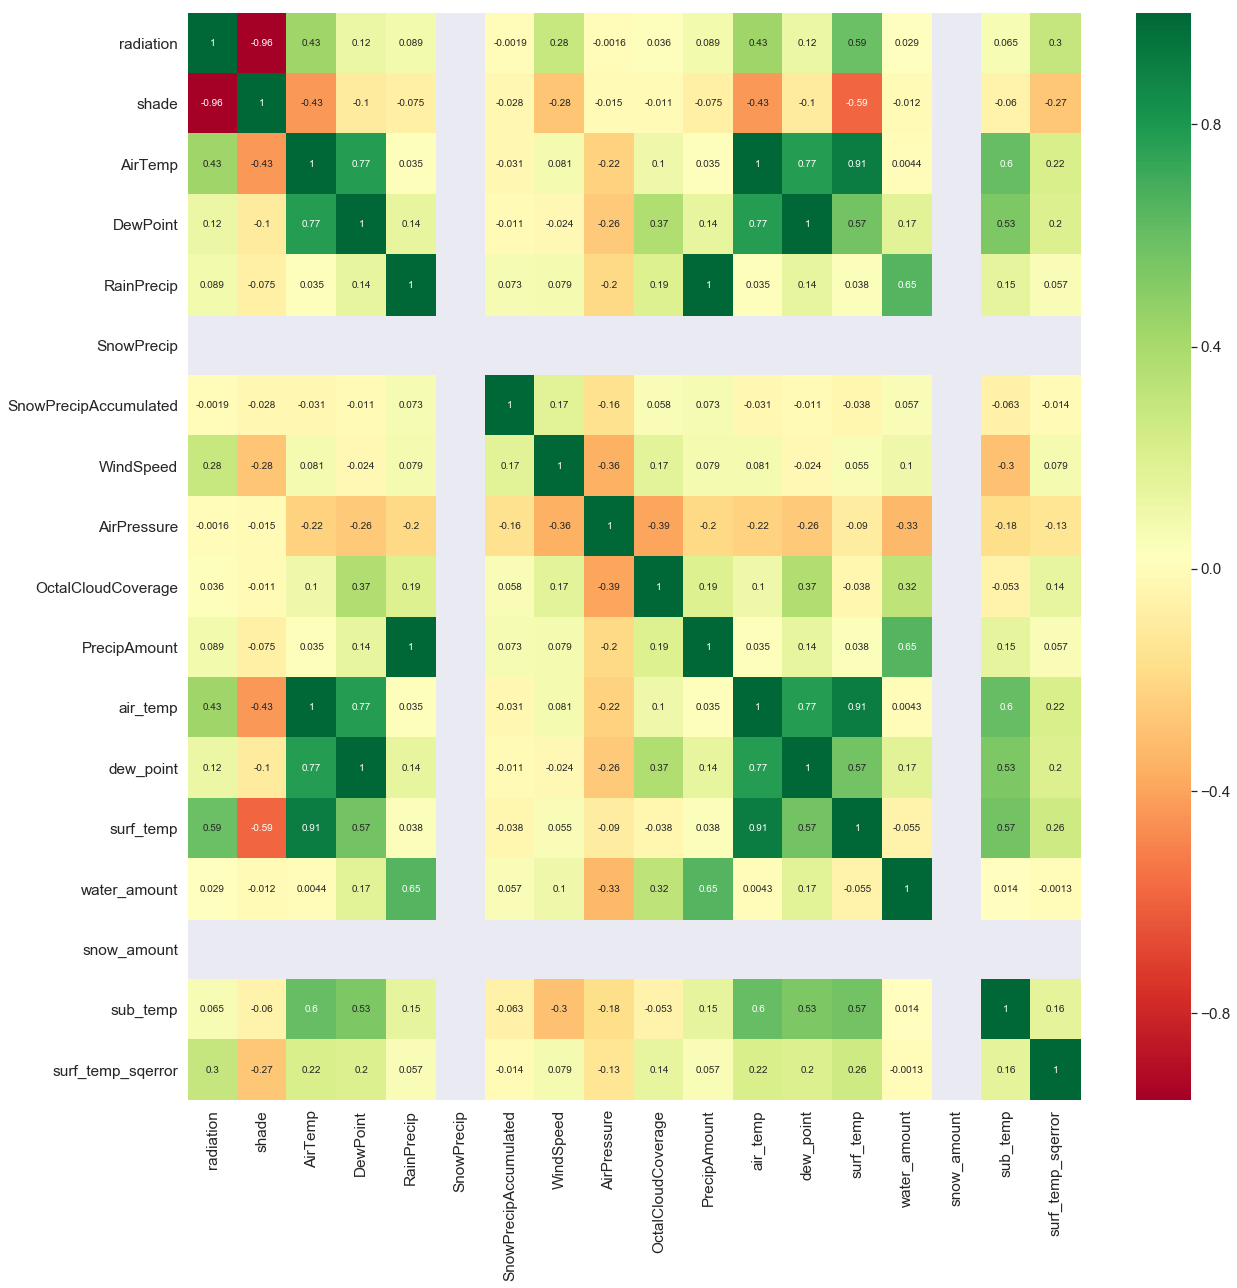

In [82]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = loader2()[(1440, 18)].filter(INDEPENDENT_FEATURES + ['surf_temp_sqerror'])
df = loader2()

#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")